### Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\nives\AllFolders\SML\mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 16, 9, 12, 982551)

### Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_BERLIN_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
#street=location['street']

2025-11-17 16:09:57,513 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 16:09:57,519 INFO: Initializing external client
2025-11-17 16:09:57,521 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 16:09:59,800 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175


### Download the model from Model Registry

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_berlin",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 16:11:25,569 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/591676 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90209 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/88014 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90822 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/87197 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/88220 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86959 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86755 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86446 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90619 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/23733 elapsed<00:00 remaining<?

In [34]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor(enable_categorical=True)

retrieved_xgboost_model.load_model(saved_model_dir + "/model_berlin.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.686384E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None,
             feature_types=['c', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Get Weather Forecast Features with Feature View



In [75]:
weather_fg = fs.get_feature_group(
    name='weather_berlin',
    version=1,
)

yesterday = today - datetime.timedelta(days = 1)
batch_data = weather_fg.filter(weather_fg.date > yesterday).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,5.20,0.0,18.598450,255.425735,Berlin
1,2025-11-17 00:00:00+00:00,5.60,0.0,11.709688,315.000092,Berlin
2,2025-11-19 00:00:00+00:00,4.15,0.0,15.905319,185.194336,Berlin
3,2025-11-20 00:00:00+00:00,2.90,0.1,17.873556,260.727478,Berlin
4,2025-11-22 00:00:00+00:00,0.65,0.0,4.693826,147.528824,Berlin
5,2025-11-21 00:00:00+00:00,1.05,0.0,7.920000,270.000000,Berlin
6,2025-11-23 00:00:00+00:00,0.70,0.3,7.208994,182.862350,Berlin


### Get today's PM25

In [76]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_berlin',
    version=1,
)

pm25_today = air_quality_fg.filter(air_quality_fg.date > (today-datetime.timedelta(days=1))).read()
pm25_today

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2025-11-17 00:00:00+00:00,46.0,17.0,17.0,51.0,Germany,Berlin,leipziger-strasse,https://api.waqi.info/feed/@13852
1,2025-11-17 00:00:00+00:00,42.0,17.0,14.0,48.0,Germany,Berlin,neukolln-nansenstrasse,https://api.waqi.info/feed/@10032
2,2025-11-17 00:00:00+00:00,46.0,34.0,19.0,52.0,Germany,Berlin,karl-marx-strasse,https://api.waqi.info/feed/@13851
3,2025-11-17 00:00:00+00:00,25.0,13.0,11.0,38.0,Germany,Berlin,buch,https://api.waqi.info/feed/@10033
4,2025-11-17 00:00:00+00:00,42.0,17.0,12.0,47.0,Germany,Berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
5,2025-11-17 00:00:00+00:00,53.0,21.0,18.0,53.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
6,2025-11-17 00:00:00+00:00,46.0,30.0,16.0,52.0,Germany,Berlin,neukolln-silbersteinstrasse,https://api.waqi.info/feed/@10036
7,2025-11-17 00:00:00+00:00,42.0,17.0,15.0,55.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132
8,2025-11-17 00:00:00+00:00,38.0,17.0,13.0,47.0,Germany,Berlin,wedding-amrumer-strasse,https://api.waqi.info/feed/@10030
9,2025-11-17 00:00:00+00:00,25.0,13.0,16.0,54.0,Germany,Berlin,friedrichshagen,https://api.waqi.info/feed/@10034


In [77]:
# Sort batch_data
batch_data = batch_data.sort_values(by=['date'], ignore_index=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,5.60,0.0,11.709688,315.000092,Berlin
1,2025-11-18 00:00:00+00:00,5.20,0.0,18.598450,255.425735,Berlin
2,2025-11-19 00:00:00+00:00,4.15,0.0,15.905319,185.194336,Berlin
3,2025-11-20 00:00:00+00:00,2.90,0.1,17.873556,260.727478,Berlin
4,2025-11-21 00:00:00+00:00,1.05,0.0,7.920000,270.000000,Berlin
5,2025-11-22 00:00:00+00:00,0.65,0.0,4.693826,147.528824,Berlin
6,2025-11-23 00:00:00+00:00,0.70,0.3,7.208994,182.862350,Berlin


### Making the predictions

In [ ]:
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

In [78]:
# Just in case there are more rows retrieved
pm25_today = pm25_today.sort_values(by=['date'], ascending=False)

result_df = pd.DataFrame()
datapoint = pd.DataFrame()
datapoint = pm25_today[['pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'street']].copy()
datapoint['street'] = datapoint['street'].astype("category")

for i in range(batch_data.shape[0]):
    datapoint['temperature_2m_mean'] = batch_data.iloc[i]['temperature_2m_mean']
    datapoint['precipitation_sum'] = batch_data.iloc[i]['precipitation_sum']
    datapoint['wind_speed_10m_max'] = batch_data.iloc[i]['wind_speed_10m_max']
    datapoint['wind_direction_10m_dominant'] = batch_data.iloc[i]['wind_direction_10m_dominant']

    # Reorder columns (the model requires a certain order)
    datapoint = datapoint[['street', 'pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    pm25_predicted = retrieved_xgboost_model.predict(datapoint)

    datapoint['predicted_pm25'] = pd.DataFrame(pm25_predicted)
    datapoint['date'] = batch_data.iloc[i]['date']
    datapoint['days_before_forecast_day'] = i+1

    result_df = pd.concat([result_df, datapoint], ignore_index=True)

    datapoint['pm25_lagged_3'] = datapoint['pm25_lagged_2']
    datapoint['pm25_lagged_2'] = datapoint['pm25_lagged_1']
    datapoint['pm25_lagged_1'] = datapoint['predicted_pm25']

batch_data = result_df

batch_data

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day
0,leipziger-strasse,17.000000,17.000000,51.000000,5.6,0.0,11.709688,315.000092,30.609676,2025-11-17 00:00:00+00:00,1
1,neukolln-nansenstrasse,17.000000,14.000000,48.000000,5.6,0.0,11.709688,315.000092,28.308147,2025-11-17 00:00:00+00:00,1
2,karl-marx-strasse,34.000000,19.000000,52.000000,5.6,0.0,11.709688,315.000092,39.960510,2025-11-17 00:00:00+00:00,1
3,buch,13.000000,11.000000,38.000000,5.6,0.0,11.709688,315.000092,21.201523,2025-11-17 00:00:00+00:00,1
4,mitte--bruckenstrasse,17.000000,12.000000,47.000000,5.6,0.0,11.709688,315.000092,30.325975,2025-11-17 00:00:00+00:00,1
...,...,...,...,...,...,...,...,...,...,...,...
65,mariendorf--mariendorfer-damm,64.143250,58.299557,48.584572,0.7,0.3,7.208994,182.862350,75.787445,2025-11-23 00:00:00+00:00,7
66,neukolln-silbersteinstrasse,70.369278,50.324272,50.676792,0.7,0.3,7.208994,182.862350,80.540161,2025-11-23 00:00:00+00:00,7
67,karl-liebknecht-strasse,60.416126,56.056446,50.293243,0.7,0.3,7.208994,182.862350,74.609283,2025-11-23 00:00:00+00:00,7
68,wedding-amrumer-strasse,47.610580,53.045181,38.990803,0.7,0.3,7.208994,182.862350,56.709892,2025-11-23 00:00:00+00:00,7


In [79]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   street                       70 non-null     category               
 1   pm25_lagged_1                70 non-null     float32                
 2   pm25_lagged_2                70 non-null     float32                
 3   pm25_lagged_3                70 non-null     float32                
 4   temperature_2m_mean          70 non-null     float32                
 5   precipitation_sum            70 non-null     float32                
 6   wind_speed_10m_max           70 non-null     float32                
 7   wind_direction_10m_dominant  70 non-null     float32                
 8   predicted_pm25               70 non-null     float32                
 9   date                         70 non-null     datetime64[us, Etc/UTC]
 10  days

### Saving the predictions (for monitoring) to a Feature Group

In [80]:
#batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
#batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day,city,country
0,leipziger-strasse,17.000000,17.000000,51.000000,5.6,0.0,11.709688,315.000092,30.609676,2025-11-17 00:00:00+00:00,1,Berlin,Germany
1,neukolln-nansenstrasse,17.000000,14.000000,48.000000,5.6,0.0,11.709688,315.000092,28.308147,2025-11-17 00:00:00+00:00,1,Berlin,Germany
2,karl-marx-strasse,34.000000,19.000000,52.000000,5.6,0.0,11.709688,315.000092,39.960510,2025-11-17 00:00:00+00:00,1,Berlin,Germany
3,buch,13.000000,11.000000,38.000000,5.6,0.0,11.709688,315.000092,21.201523,2025-11-17 00:00:00+00:00,1,Berlin,Germany
4,mitte--bruckenstrasse,17.000000,12.000000,47.000000,5.6,0.0,11.709688,315.000092,30.325975,2025-11-17 00:00:00+00:00,1,Berlin,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,mitte--bruckenstrasse,52.631733,54.868511,43.995865,0.7,0.3,7.208994,182.862350,61.473225,2025-11-23 00:00:00+00:00,7,Berlin,Germany
65,mariendorf--mariendorfer-damm,64.143250,58.299557,48.584572,0.7,0.3,7.208994,182.862350,75.787445,2025-11-23 00:00:00+00:00,7,Berlin,Germany
66,neukolln-silbersteinstrasse,70.369278,50.324272,50.676792,0.7,0.3,7.208994,182.862350,80.540161,2025-11-23 00:00:00+00:00,7,Berlin,Germany
67,karl-liebknecht-strasse,60.416126,56.056446,50.293243,0.7,0.3,7.208994,182.862350,74.609283,2025-11-23 00:00:00+00:00,7,Berlin,Germany


In [81]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   street                       70 non-null     category               
 1   pm25_lagged_1                70 non-null     float32                
 2   pm25_lagged_2                70 non-null     float32                
 3   pm25_lagged_3                70 non-null     float32                
 4   temperature_2m_mean          70 non-null     float32                
 5   precipitation_sum            70 non-null     float32                
 6   wind_speed_10m_max           70 non-null     float32                
 7   wind_direction_10m_dominant  70 non-null     float32                
 8   predicted_pm25               70 non-null     float32                
 9   date                         70 non-null     datetime64[us, Etc/UTC]
 10  days_befo

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo.
Show it on github pages

leipziger-strasse
2025-11-17 20:45:34,933 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

neukolln-nansenstrasse
karl-marx-strasse
buch
mitte--bruckenstrasse
mariendorf--mariendorfer-damm
neukolln-silbersteinstrasse
karl-liebknecht-strasse
wedding-amrumer-strasse
friedrichshagen


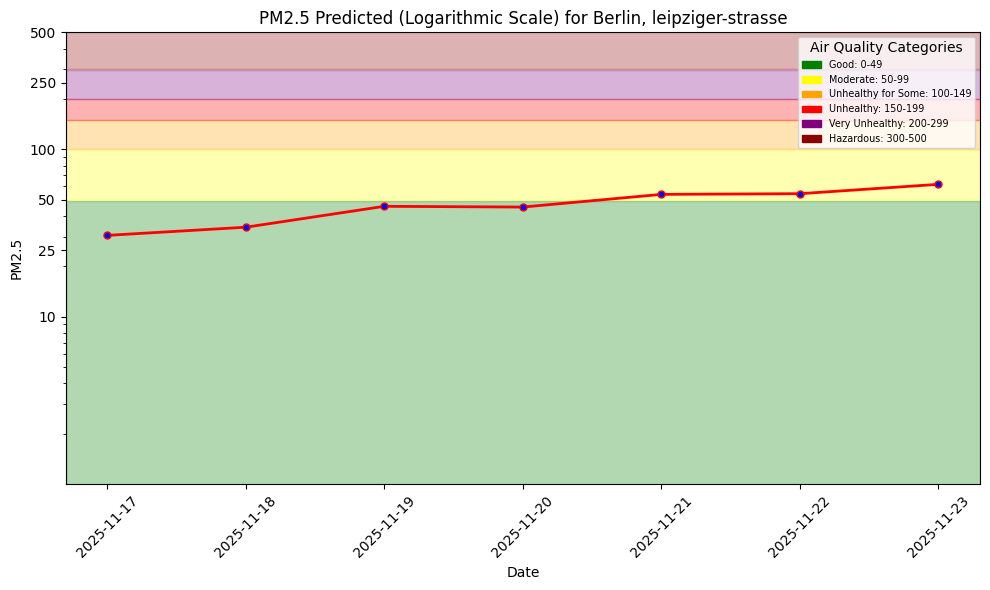

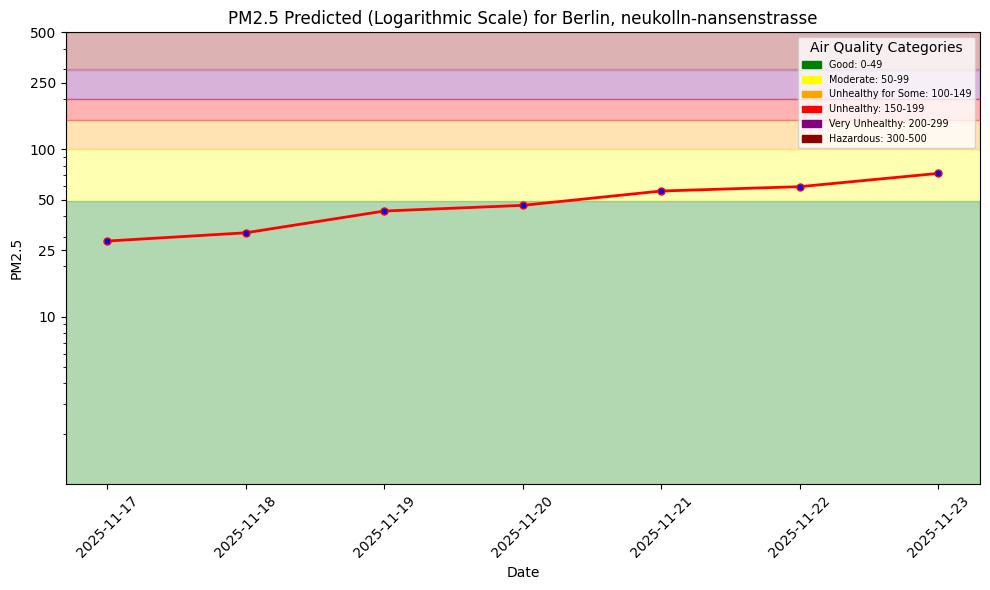

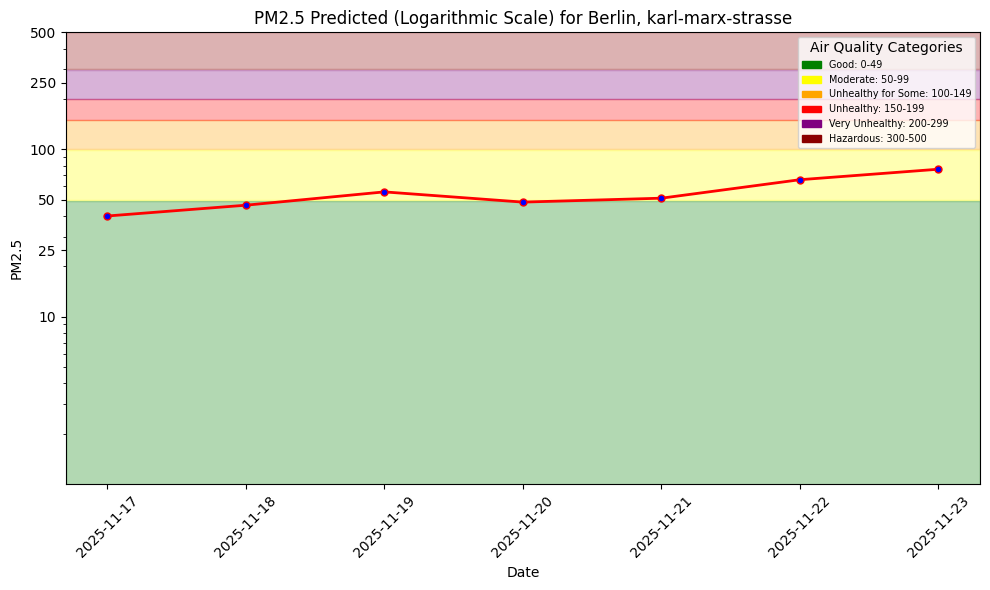

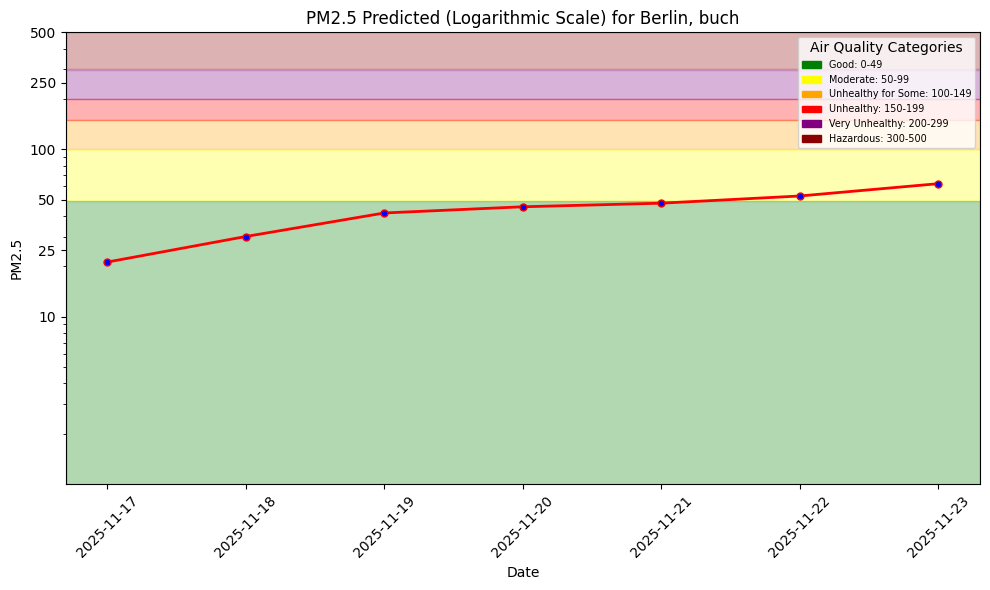

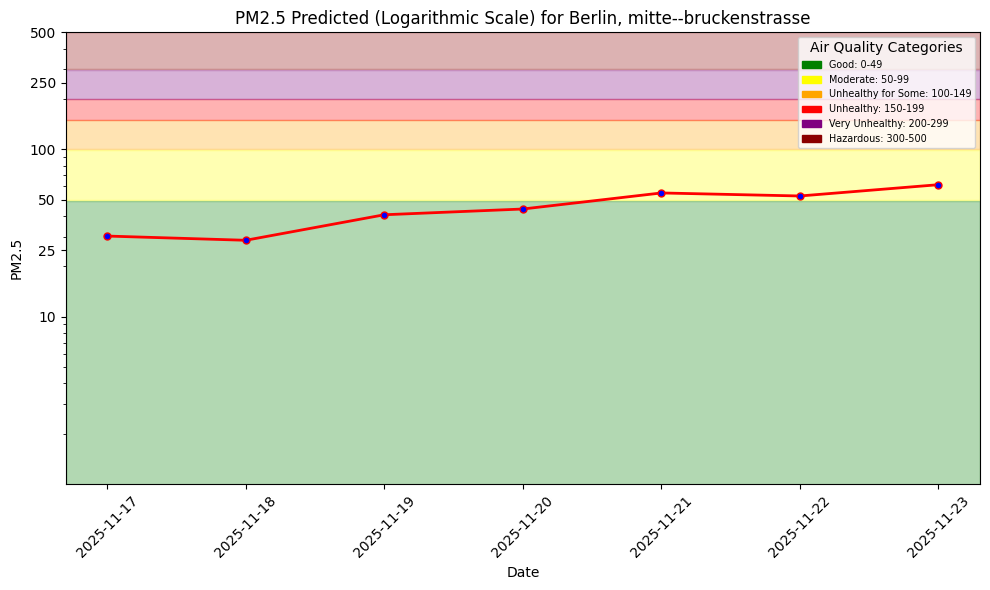

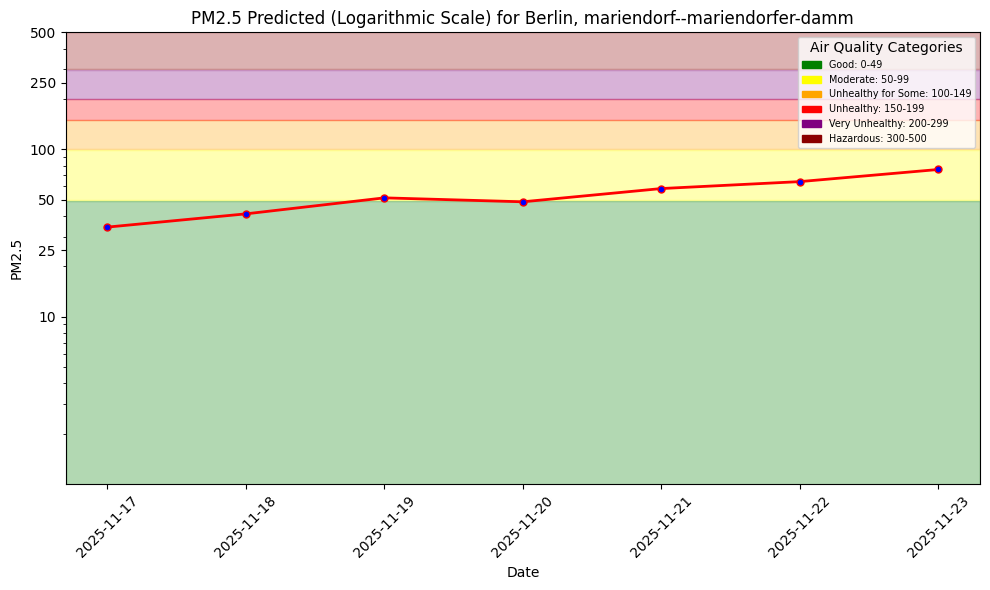

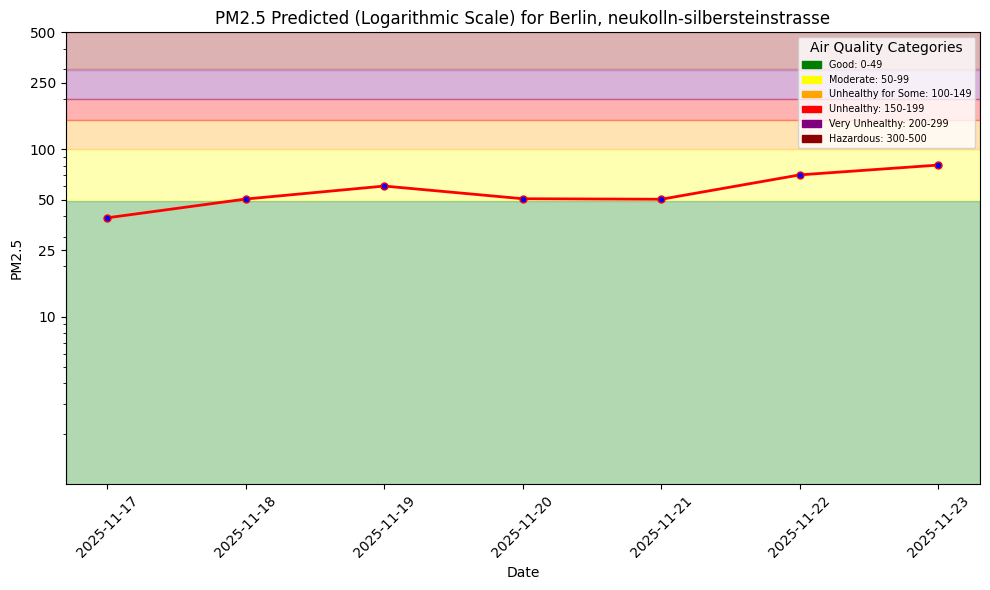

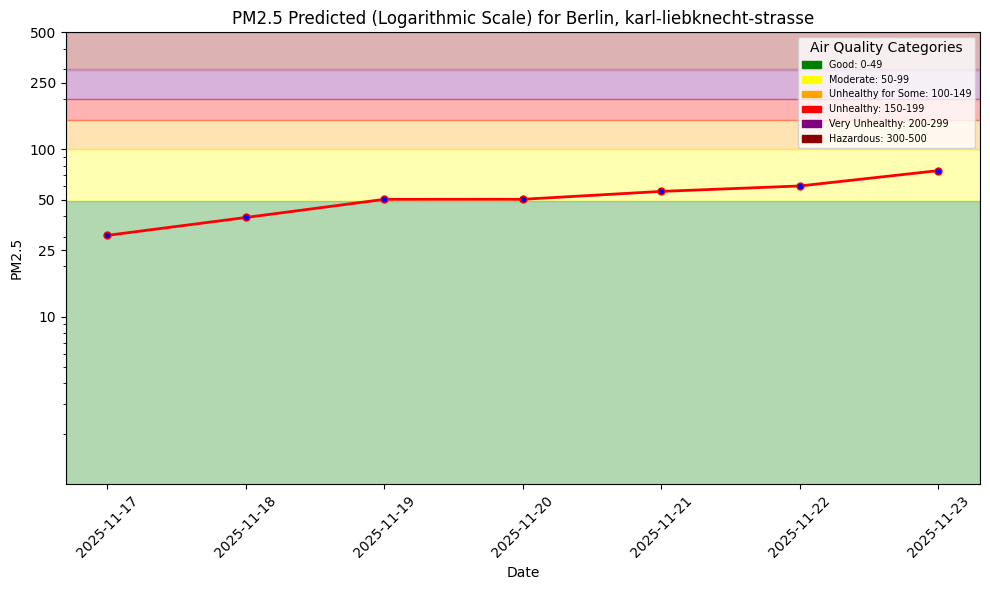

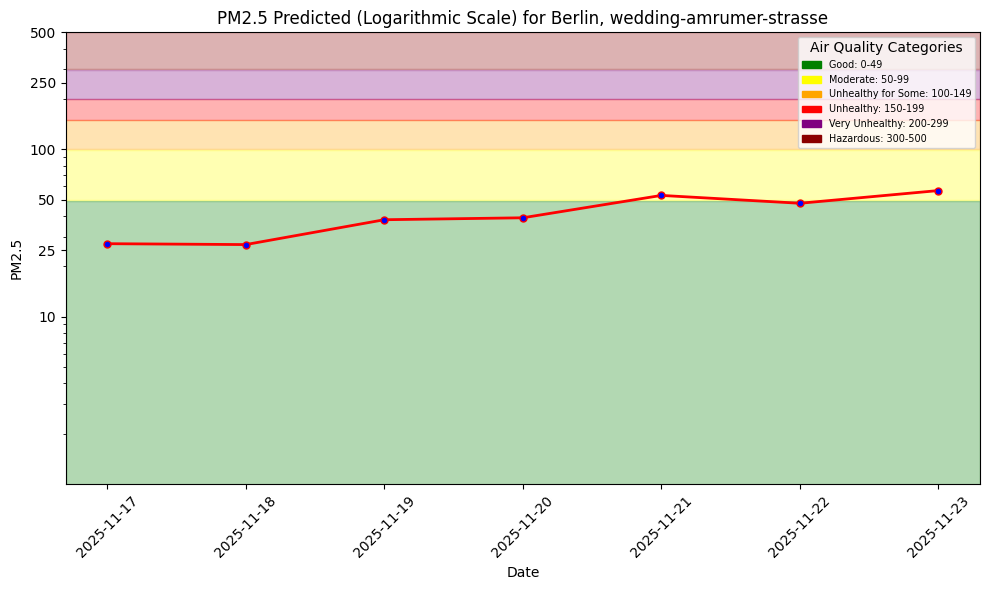

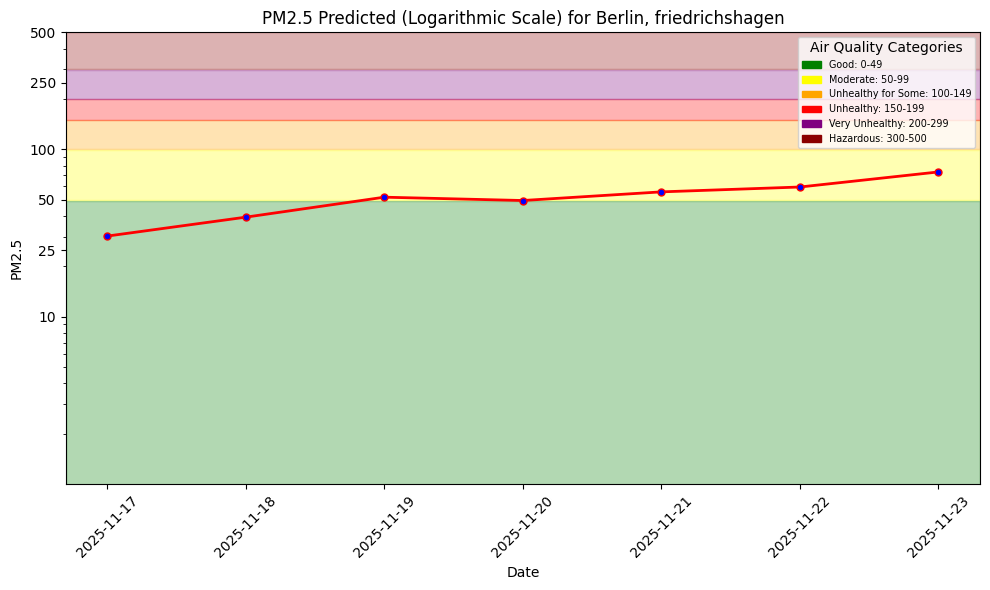

In [84]:
metadata = pd.DataFrame()
metadata['street'] = batch_data['street'].drop_duplicates()  
metadata

for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']
    print(street)

    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_"+street+".png"
    batch_data_i = batch_data[batch_data['street'] == street]
    #plt = util.plot_air_quality_forecast(city, street, df_i, file_path, hindcast=True)
    plt = util.plot_air_quality_forecast(city, street, batch_data_i, pred_file_path)
plt.show()

In [85]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_berlin',
    description='Air Quality prediction monitoring for Berlin',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [86]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279175/fs/1265791/fg/1730953


Uploading Dataframe: 100.00% |██████████| Rows 70/70 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_berlin_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279175/jobs/named/aq_predictions_berlin_1_offline_fg_materialization/executions
2025-11-17 20:49:14,529 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 20:49:17,699 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 20:50:50,033 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 20:50:50,202 INFO: Waiting for log aggregation to finish.
2025-11-17 20:51:08,811 INFO: Execution finished successfully.


(Job('aq_predictions_berlin_1_offline_fg_materialization', 'SPARK'), None)

In [87]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day,city,country
0,buch,13.0,11.0,38.0,5.6,0.0,11.709688,315.000092,21.201523,2025-11-17 00:00:00+00:00,1,Berlin,Germany
1,neukolln-nansenstrasse,17.0,14.0,48.0,5.6,0.0,11.709688,315.000092,28.308147,2025-11-17 00:00:00+00:00,1,Berlin,Germany
2,wedding-amrumer-strasse,17.0,13.0,47.0,5.6,0.0,11.709688,315.000092,27.300888,2025-11-17 00:00:00+00:00,1,Berlin,Germany
3,leipziger-strasse,17.0,17.0,51.0,5.6,0.0,11.709688,315.000092,30.609676,2025-11-17 00:00:00+00:00,1,Berlin,Germany
4,karl-marx-strasse,34.0,19.0,52.0,5.6,0.0,11.709688,315.000092,39.960510,2025-11-17 00:00:00+00:00,1,Berlin,Germany
5,friedrichshagen,13.0,16.0,54.0,5.6,0.0,11.709688,315.000092,30.318336,2025-11-17 00:00:00+00:00,1,Berlin,Germany
6,neukolln-silbersteinstrasse,30.0,16.0,52.0,5.6,0.0,11.709688,315.000092,38.974941,2025-11-17 00:00:00+00:00,1,Berlin,Germany
7,karl-liebknecht-strasse,17.0,15.0,55.0,5.6,0.0,11.709688,315.000092,30.606155,2025-11-17 00:00:00+00:00,1,Berlin,Germany
8,mitte--bruckenstrasse,17.0,12.0,47.0,5.6,0.0,11.709688,315.000092,30.325975,2025-11-17 00:00:00+00:00,1,Berlin,Germany
9,mariendorf--mariendorfer-damm,21.0,18.0,53.0,5.6,0.0,11.709688,315.000092,34.295467,2025-11-17 00:00:00+00:00,1,Berlin,Germany


In [88]:
air_quality_fg = fs.get_feature_group(name='air_quality_berlin', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.13s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2025-03-12 00:00:00+00:00,84.0,133.0,133.0,122.0,Germany,Berlin,friedrichshagen,https://api.waqi.info/feed/@10034
1,2024-10-15 00:00:00+00:00,42.0,41.0,32.0,43.0,Germany,Berlin,neukolln-silbersteinstrasse,https://api.waqi.info/feed/@10036
2,2024-01-20 00:00:00+00:00,65.0,56.0,86.0,68.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132
3,2025-02-27 00:00:00+00:00,56.0,73.0,57.0,50.0,Germany,Berlin,wedding-amrumer-strasse,https://api.waqi.info/feed/@10030
4,2023-10-19 00:00:00+00:00,73.0,57.0,48.0,29.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
...,...,...,...,...,...,...,...,...,...
12929,2025-11-17 00:00:00+00:00,53.0,21.0,18.0,53.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
12930,2025-11-17 00:00:00+00:00,46.0,30.0,16.0,52.0,Germany,Berlin,neukolln-silbersteinstrasse,https://api.waqi.info/feed/@10036
12931,2025-11-17 00:00:00+00:00,42.0,17.0,15.0,55.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132
12932,2025-11-17 00:00:00+00:00,38.0,17.0,13.0,47.0,Germany,Berlin,wedding-amrumer-strasse,https://api.waqi.info/feed/@10030


In [ ]:
outcome_df = air_quality_df[['date', 'pm25', 'street']]
preds_df =  monitoring_df[['date', 'predicted_pm25', 'street']]

hindcast_df = pd.merge(preds_df, outcome_df, on=["date","street"])
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_berlin(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,street,pm25
0,2025-11-17 00:00:00+00:00,21.201523,buch,25.0
1,2025-11-17 00:00:00+00:00,28.308147,neukolln-nansenstrasse,42.0
2,2025-11-17 00:00:00+00:00,27.300888,wedding-amrumer-strasse,38.0
3,2025-11-17 00:00:00+00:00,30.609676,leipziger-strasse,46.0
4,2025-11-17 00:00:00+00:00,39.960510,karl-marx-strasse,46.0
5,2025-11-17 00:00:00+00:00,30.318336,friedrichshagen,25.0
6,2025-11-17 00:00:00+00:00,38.974941,neukolln-silbersteinstrasse,46.0
7,2025-11-17 00:00:00+00:00,30.606155,karl-liebknecht-strasse,42.0
8,2025-11-17 00:00:00+00:00,30.325975,mitte--bruckenstrasse,42.0
9,2025-11-17 00:00:00+00:00,34.295467,mariendorf--mariendorfer-damm,53.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

leipziger-strasse
neukolln-nansenstrasse
karl-marx-strasse
buch
mitte--bruckenstrasse
mariendorf--mariendorfer-damm
neukolln-silbersteinstrasse
karl-liebknecht-strasse
wedding-amrumer-strasse
friedrichshagen


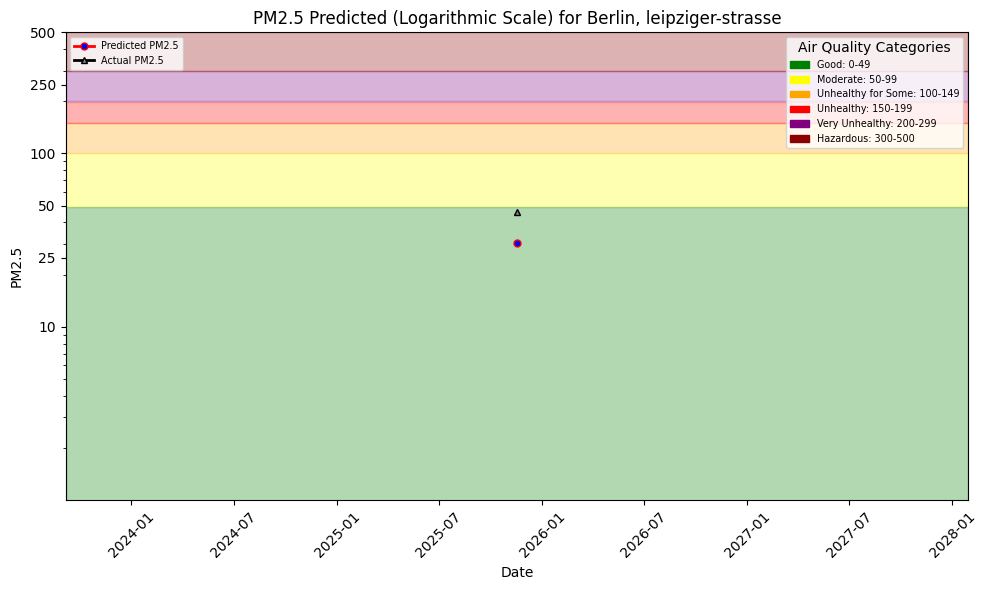

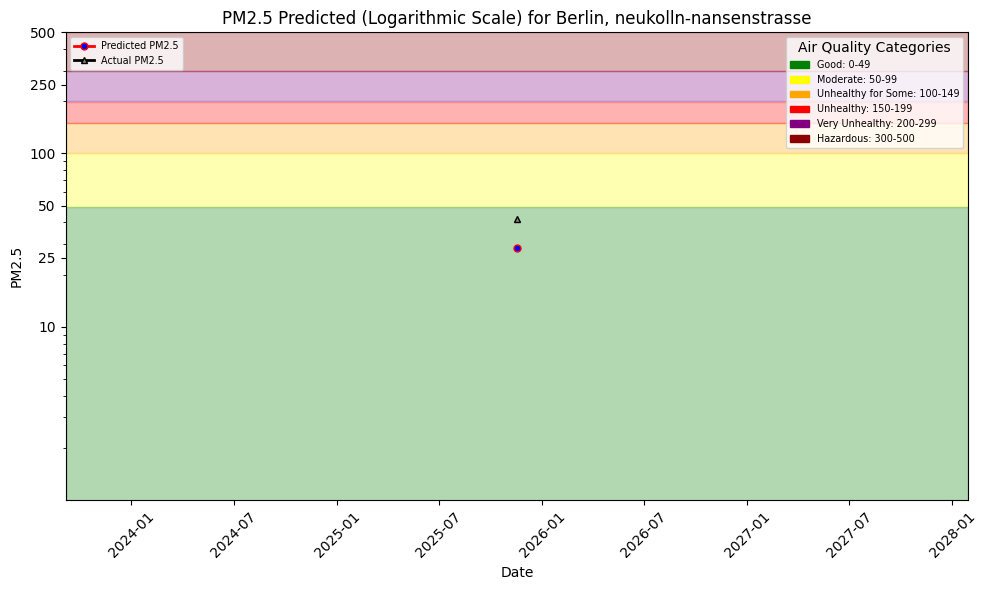

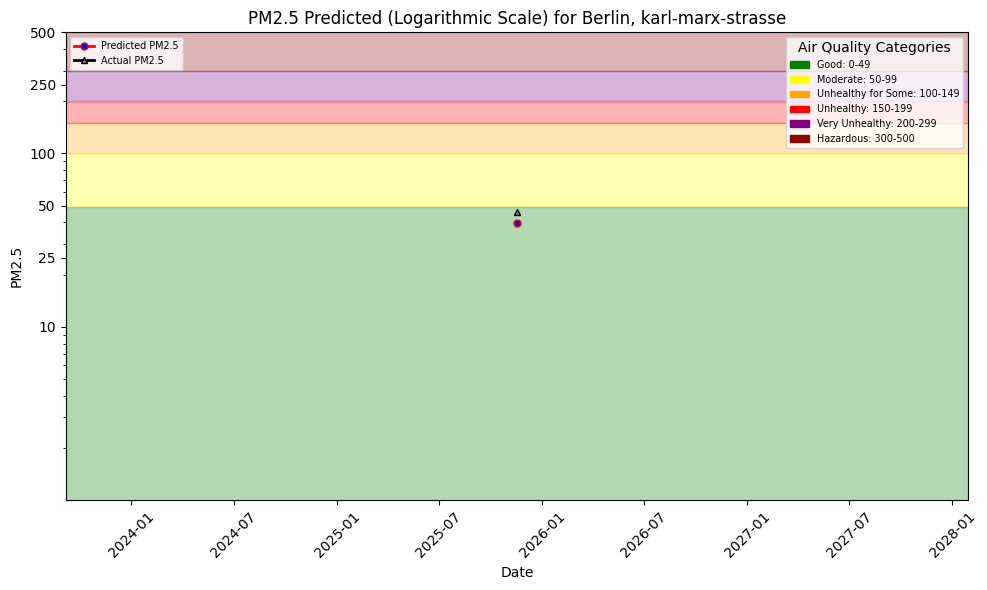

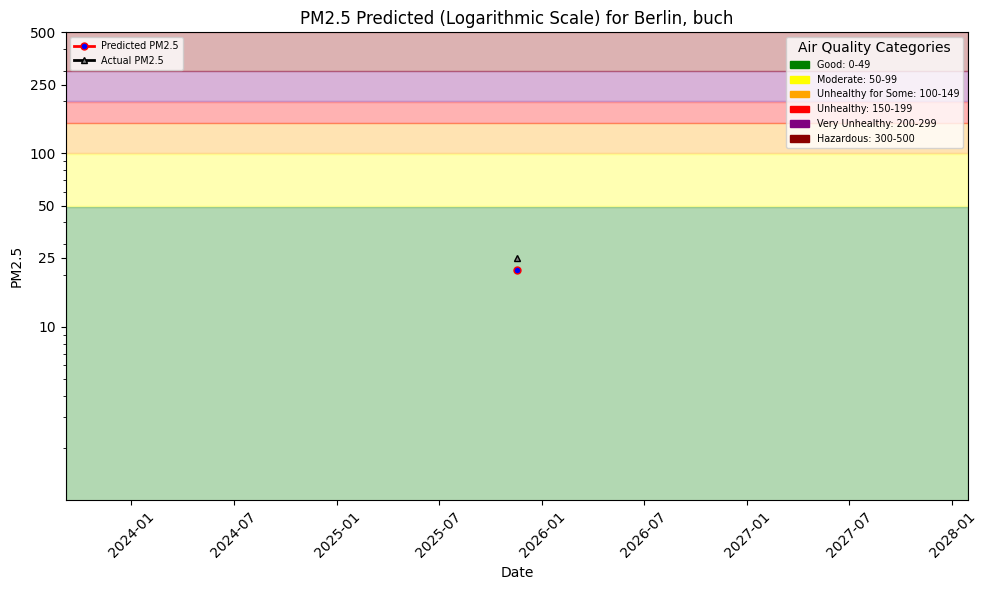

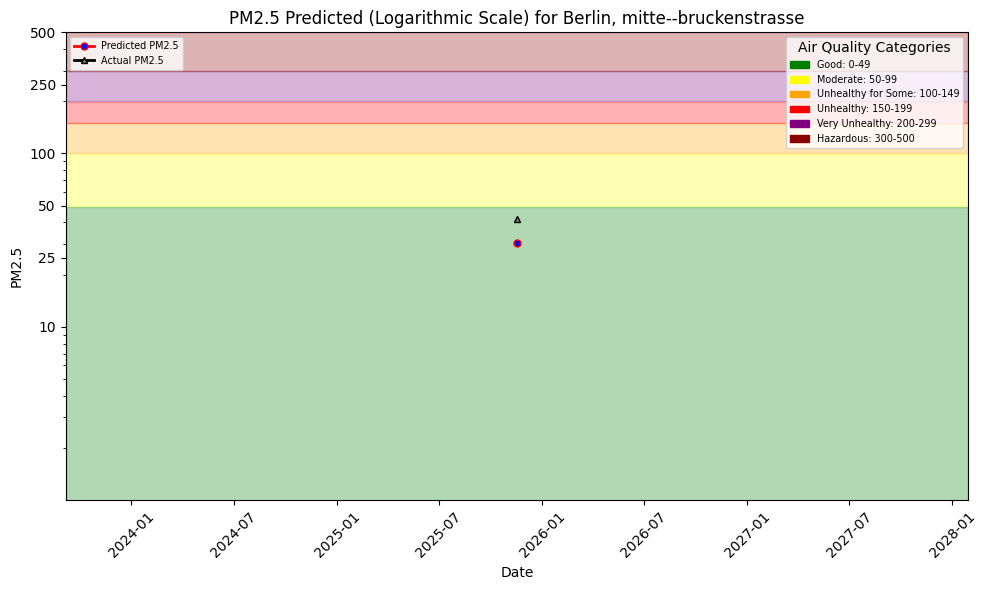

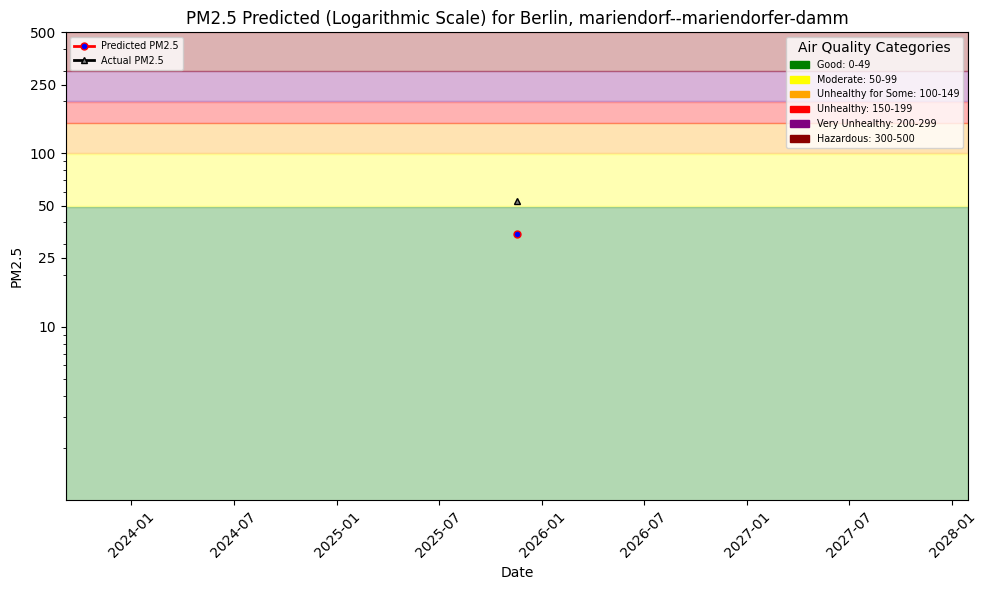

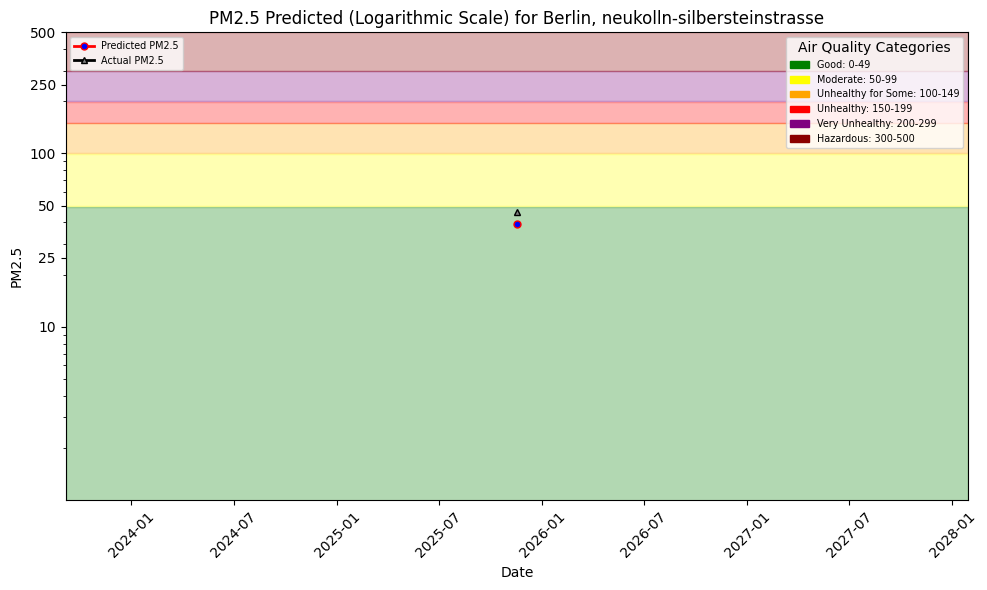

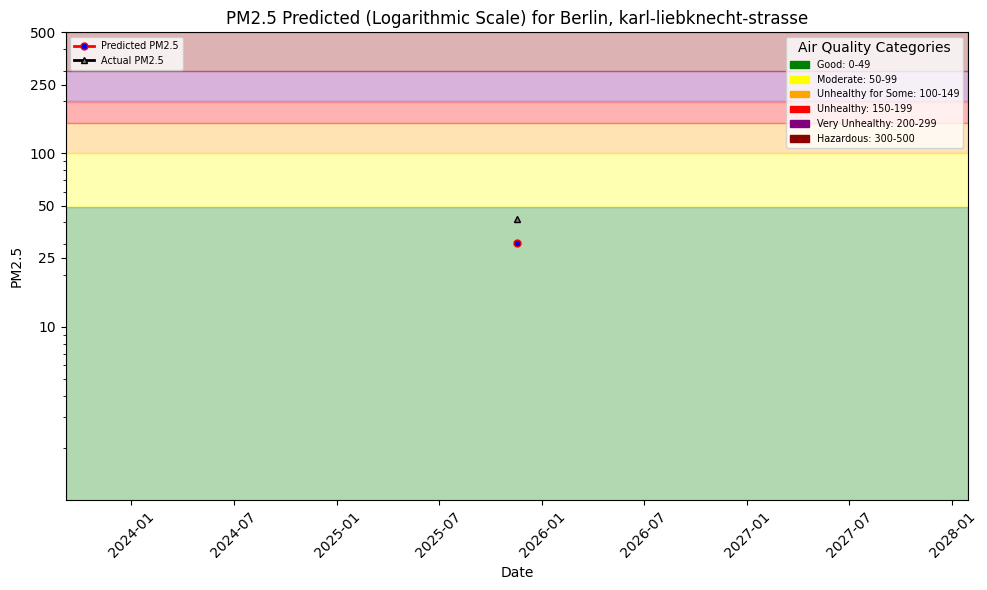

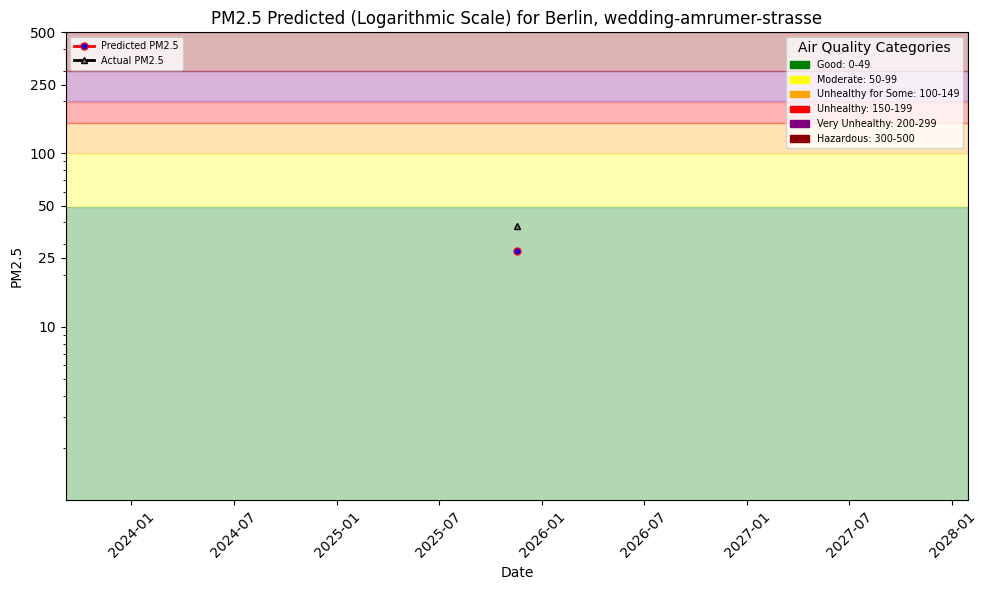

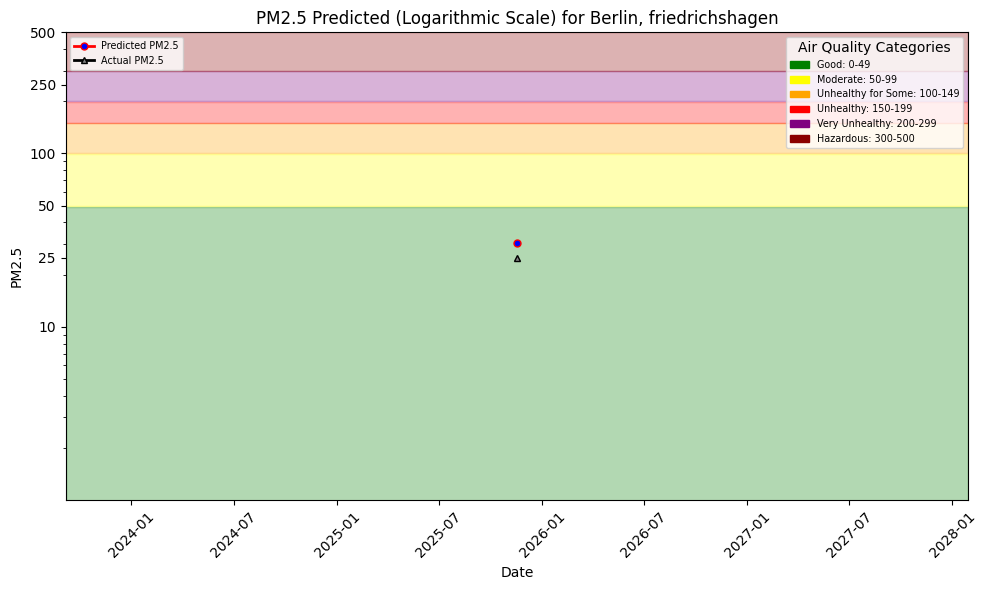

In [123]:
for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']
    print(street)

    hindcast_df_i = hindcast_df[hindcast_df['street'] == street]
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day"+street+".png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df_i, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [124]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']

    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_"+street+".png"
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day"+street+".png"

    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_leipziger-strasse.…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1dayleipziger-stra…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_neukolln-nansenstr…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1dayneukolln-nanse…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_karl-marx-strasse.…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daykarl-marx-stra…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_buch.png: 0.000%| …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daybuch.png: 0.00…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_mitte--bruckenstra…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daymitte--brucken…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_mariendorf--marien…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daymariendorf--ma…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_neukolln-silberste…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1dayneukolln-silbe…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_karl-liebknecht-st…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daykarl-liebknech…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_wedding-amrumer-st…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1daywedding-amrume…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast_friedrichshagen.pn…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1dayfriedrichshage…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279175/settings/fb/path/Resources/airquality
